### Sandbox

- This notebook works for the following models only
    - mvtec-cable
    - mvtec-capsule
    - mvtec-grid
    - mvtec-metalnut
    - mvtec-screw
    - mvtec-toothbrush
    - mvtec-zipper


- For other trained models (that only include the full model), use the `app/full_evaluation.ipynb` notebook

In [63]:

import tensorflow as tf

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [94]:
# load the trained model

from sspcab.sspcab_tf import SSPCAB

# modify this only if you have changed the model path
BASE_PATH = '../saved_models/basic/mvtec-cable'

MODEL_PATH = f'{BASE_PATH}/model.h5'
MODEL_HISTORY_PATH = f'{BASE_PATH}/history.json'
FEATURE_EXTRACTOR_PATH = f'{BASE_PATH}/feature_extractor.h5'
KDE_PATH = f'{BASE_PATH}/kde.pickle'

model = tf.keras.models.load_model(MODEL_PATH, custom_objects={'SSPCAB': SSPCAB})
feature_extractor = tf.keras.models.load_model(FEATURE_EXTRACTOR_PATH)
kde = pickle.load(open(KDE_PATH, 'rb'))


### Display the learning curves of the model

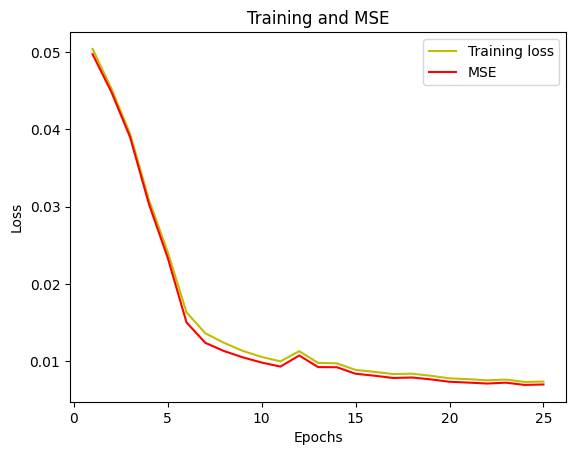

In [95]:
import json

history = json.load(open(MODEL_HISTORY_PATH, 'r'))

# plot the training history
loss = history['loss']
mse = history['mse']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, mse, 'r', label='MSE')
plt.title('Training and MSE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing the model

In [96]:
from keras.preprocessing.image import ImageDataGenerator

# Modify this and Run all cells below to test on different datasets
DATASET_PATH = '../datasets/mvtecad/cable/' 

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(128, 128),
    batch_size=32,
    class_mode='input',
    classes=['train']
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH + 'test/',
    target_size=(128, 128),
    batch_size=32,
    class_mode='input',
    classes=['good']
    )

anomaly_generator = datagen.flow_from_directory(
    DATASET_PATH + 'test/',
    target_size=(128, 128),
    batch_size=32,
    class_mode='input',
    classes=['defective']
    )

Found 224 images belonging to 1 classes.
Found 58 images belonging to 1 classes.
Found 92 images belonging to 1 classes.


In [97]:
density_threshold = 11300 # based on the mean and std dev. of the density
reconstruction_error_threshold = np.Infinity # Based on the mean and std dev. of the reconstruction error

In [98]:
def check_anomaly(img_path):
    img  = Image.open(img_path)
    img = img.convert('RGB')

    img = np.array(img.resize((128,128), Image.Resampling.LANCZOS))
    
    original_img = img.copy()
    
    img = img / 255.
    img = img[np.newaxis, :,:,:]


    encoded_img = feature_extractor.predict([[img]]) 
    encoded_img = [np.reshape(img, (128 * 128)) for img in encoded_img] 
    
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]

    reconstruction_loss = np.abs(img - reconstruction)
    reconstruction_loss = np.mean(reconstruction_loss, axis=3)[0]
    
    return (density < density_threshold or reconstruction_error > reconstruction_error_threshold), original_img, reconstruction_loss

In [101]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
defective_file_paths = glob.glob(f'{DATASET_PATH}/test/defective/**/*')
normal_file_paths = glob.glob(f'{DATASET_PATH}/test/good/*')

1/1 [==============================] - 0s 77ms/step - loss: 0.0068 - mse: 0.0065 - mae: 0.0604


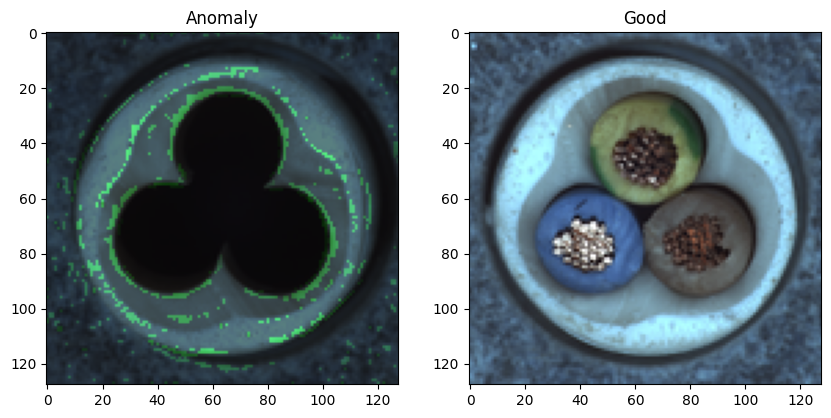

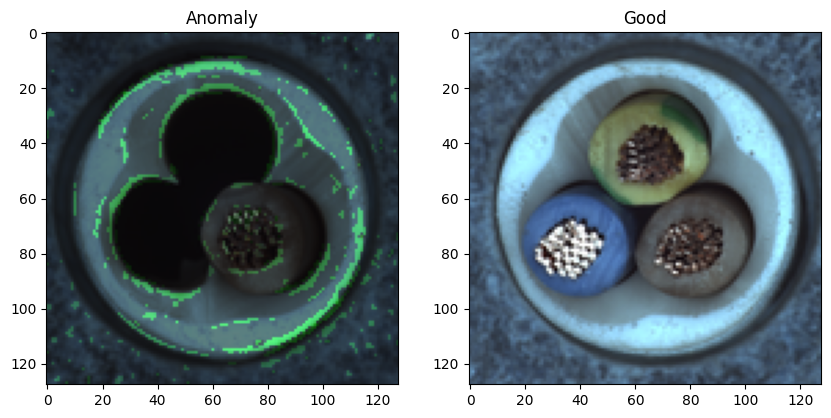

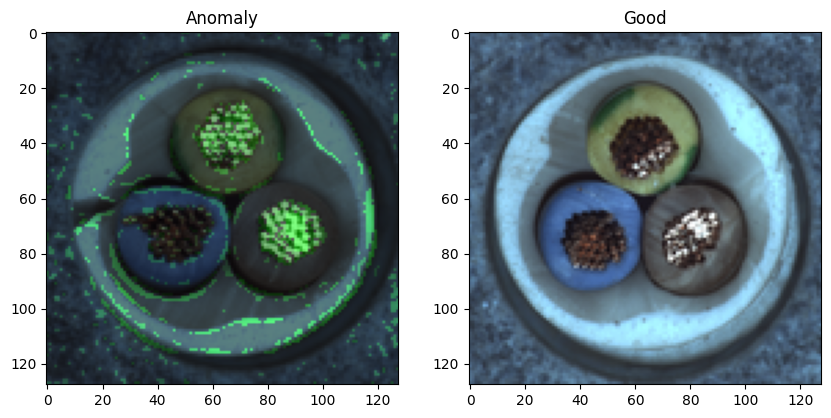

In [103]:
import cv2

for _ in range(3):
    defective_img = defective_file_paths[np.random.randint(0, len(defective_file_paths))]
    is_detected, img1, loss = check_anomaly(defective_img)

    normal_img = normal_file_paths[np.random.randint(0, len(normal_file_paths))]
    is_misclassified, img2, _ = check_anomaly(normal_img)
    

    fig, ax = plt.subplots(1,2, figsize=(10,10))

    ax[0].imshow(img1)
    ax[0].set_title("Anomaly" if is_detected else "Good")
    
    # add a mask of the reconstruction loss as a heatmap
    mask = loss > 0.1
    overlay = img1.copy()
    overlay[mask] = [0, 255, 0]

    new_overlay = cv2.morphologyEx(overlay, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))

    # remove unaffected pixels
    new_overlay[~mask] = 0
    
    # only overlay the mask if the pixel is activated
    ax[0].imshow(new_overlay, alpha=0.5, cmap='binary', vmin=0, vmax=1)
    
        
    ax[1].imshow(img2)
    ax[1].set_title("Anomaly" if is_misclassified else "Good")

In [104]:
def roc_auc_score(y_true, y_pred):
    return np.mean(np.array(y_true) == np.array(y_pred))

y_true = []
y_pred = []

for img_path in defective_file_paths:
    is_detected, _, _ = check_anomaly(img_path)
    y_true.append(1)
    y_pred.append(int(is_detected))
    
for img_path in normal_file_paths:
    is_detected, _, _ = check_anomaly(img_path)
    y_true.append(0)
    y_pred.append(int(is_detected))
    
print("ROC AUC score: ", roc_auc_score(y_true, y_pred))
print('False positives: ', y_pred.count(1) - y_true.count(1))

1/1 [==============================] - 0s 101ms/step - loss: 0.0083 - mse: 0.0081 - mae: 0.0611
ROC AUC score:  0.9666666666666667
False positives:  5
